### In this notebook we will check the assumption that stocastic gepth help deep network predict better than without it.

### In our experements we used ResNet-50 with bottleneck blocks: https://arxiv.org/abs/1512.03385

### Stochastic depth: https://arxiv.org/abs/1603.09382

Main idea in stochastic depth similar to [dropuot](http://www.jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf), but now we drop all layer, instead some weights. 

In [2]:
import os
import sys

import blosc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqn
from collections import OrderedDict
%matplotlib inline

sys.path.append('..')
from resnet import ResBottleBatch
from dataset import Dataset, DatasetIndex

### Load data

In [3]:
src = './../MNIST_data'
with open(os.path.join(src, 'mnist_pics.blk'), 'rb') as file:
    images = blosc.unpack_array(file.read()).reshape(-1, 28, 28)
with open(os.path.join(src, 'mnist_labels.blk'), 'rb') as file:
    labels = blosc.unpack_array(file.read())

### Create dataset

In [4]:
ix = DatasetIndex(range(65000))
dset = Dataset(ix, ResBottleBatch)
dset.cv_split()

### train models 

In [8]:
stochastic_loss, bottle_loss = [], []
stochastic_acc, bottle_acc = [], []
bottle_time, stochastic_time = np.zeros(1), np.zeros(1)

train_pipeline = (dset.train.
                 p.
                 train_stochastic([images, labels], stochastic_loss, stochastic_time).
                 train_bigbottle([images, labels], bottle_loss, bottle_time))
test_pipeline = (dset.test.p
                .import_model("bigbottlenet", train_pipeline)
                .import_model("stochasticnet", train_pipeline) 
                .accuracy_stochastic([images, labels], stochastic_acc)
                .accuracy_bigbottle([images, labels], bottle_acc))
for i in tqn(range(800)):
    train_pipeline.next_batch(300, n_epochs=None, shuffle=2)
    test_pipeline.next_batch(300, n_epochs=None, shuffle=2)

Widget Javascript not detected.  It may not be installed or enabled properly.


### After train let's compare model's.

In [9]:
plt.style.use('seaborn-poster')
plt.style.use('ggplot')

def draw(bottle_loss, stochastic_loss, y):
    """ Draw graphs to compare models. The graph shows a comparison of the average 
        values calculated with a window in 10 values.
    Args:
        freeze_loss: List with loss value in resnet and freezeout model
        res_loss: List with loss value in clear resnet
        src: List with parameters of model with FreezeOut
        ax: Plt sublot """
    bl_loss = []
    st_loss = []

    for i in range(10, len(bottle_loss) - 10):
        bl_loss.append(np.mean(bottle_loss[i-10:i+10]))
        st_loss.append(np.mean(stochastic_loss[i-10:i+10]))
    
    plt.plot(bl_loss, label='Bottle {}'.format(y))
    plt.plot(st_loss, label='Stochastic {}'.format(y))
    plt.xlabel('Iteration', fontsize=16)
    plt.ylabel(y, fontsize=16)
    plt.legend(fontsize=14)
    plt.axis([0, 800, 0, 1])


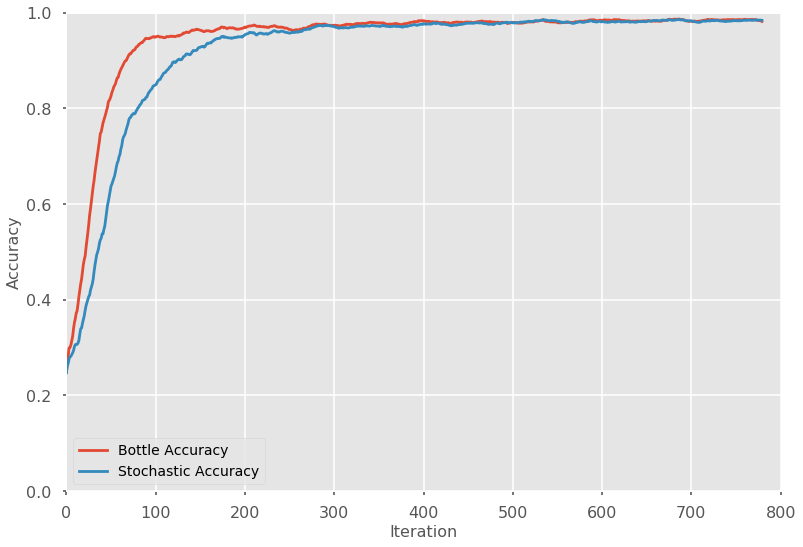

In [10]:
draw(np.array(bottle_acc)[:,0], np.array(stochastic_acc)[:,0], 'Accuracy')

### The graphs show that stochastic model at the begining loses simple model, but after 400 iteration, but after 400 iterations, she catches up with the usual model for quality and sometimes even overtakes.